In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from genomics_dl.models.heterogeneity import (
    search_best_clustering,
    run_nonmalignant_cluster_characterization,
    flag_pca_distance_outliers,
    compute_umap_from_pca,
    plot_umap,
)
from scipy.stats import chi2_contingency, f_oneway

/workspaces/TFM/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PROCESSED = Path("../data/processed")

DATA_PATH = DATA_PROCESSED /"gse183635_tep_tpm_labels.parquet"
TRAIN_PATH = DATA_PROCESSED / "gse183635_tep_tpm_train.parquet"
TEST_PATH  = DATA_PROCESSED / "gse183635_tep_tpm_test.parquet"

output_dir_figure = Path("../reports/figures/nonmalignant")


RANDOM_STATE = 42
TEST_SIZE = 0.2

metadata_cols = [
    "Sample ID",
    "Patient_group",
    "Stage",
    "Sex",
    "Age",
    "Sample-supplying institution",
    "Training series",
    "Evaluation series",
    "Validation series",
    "lib.size",
    "classificationScoreCancer",
    "Class_group",
]

In [3]:
df = pd.read_parquet(DATA_PATH)

if "Sample ID" in df.columns:
    df = df.set_index("Sample ID", drop=False)


gene_cols = [c for c in df.columns if c not in metadata_cols]

X_all = df[gene_cols]        # matriz de expresión 
meta_all = df[metadata_cols] # metadatos


# EDA poblacional básico

## Tamaños y clases

In [4]:
print("N muestras:", len(df))
print("\nDistribución por Class_group")
print(meta_all["Class_group"].value_counts(dropna=False))

print("\nDistribución por Patient_group")
print(meta_all["Patient_group"].value_counts(dropna=False))

N muestras: 2351

Distribución por Class_group
Class_group
Malignant       1628
nonMalignant     723
Name: count, dtype: int64

Distribución por Patient_group
Patient_group
Non-small-cell lung cancer        522
Asymptomatic controls             390
Ovarian cancer                    144
Glioma                            132
Pancreatic cancer                 126
Head and neck cancer              101
Breast cancer                      93
Multiple sclerosis                 86
Cholangiocarcinoma                 85
Colorectal cancer                  85
Pulmonary Hypertension             72
Melanoma                           68
Sarcoma                            53
Pancreatic diseases                50
Medically-intractable epilepsy     44
Endometrial cancer                 39
Prostate cancer                    35
Multiple Myeloma                   31
Renal cell cancer                  28
Urothelial cancer                  28
Former sarcoma                     26
Angina pectoris              

In [5]:
print("\nDistribución por Stage")
print(meta_all["Stage"].value_counts(dropna=False))



Distribución por Stage
Stage
n.a.    978
IV      861
III     235
II      166
I       111
Name: count, dtype: int64


## Edad, sexo, institución

In [6]:
print("\nResumen edad")
print(meta_all["Age"].describe())

print("\nDistribución por Sex")
print(meta_all["Sex"].value_counts(dropna=False))


Resumen edad
count    2328.000000
mean       58.490550
std        14.137847
min        18.000000
25%        51.000000
50%        61.000000
75%        69.000000
max        92.000000
Name: Age, dtype: float64

Distribución por Sex
Sex
F       1220
M       1111
n.a.      20
Name: count, dtype: int64


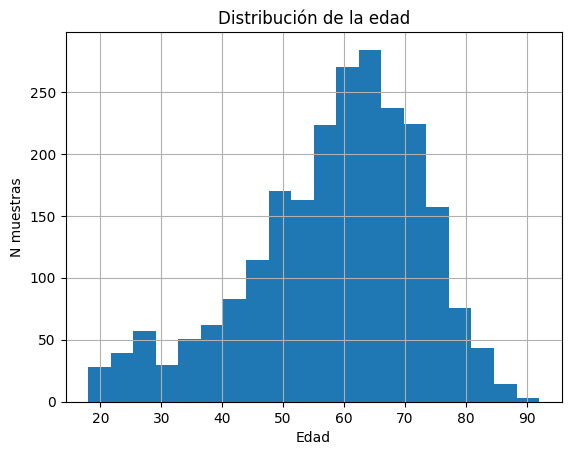

In [7]:
meta_all["Age"].hist(bins=20)
plt.xlabel("Edad")
plt.ylabel("N muestras")
plt.title("Distribución de la edad")
plt.grid(True)
plt.show()


# Split train/test estratificado

In [8]:
y_all = meta_all["Class_group"]

train_idx, test_idx = train_test_split(
    df.index,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_all # balanceado
)

print("Train:", len(train_idx), "Test:", len(test_idx))


Train: 1880 Test: 471


In [9]:
df_train = df.loc[train_idx].copy()
df_test  = df.loc[test_idx].copy()


df_train.to_parquet(TRAIN_PATH, index=False)
df_test.to_parquet(TEST_PATH, index=False)

# Guardar solo los IDs para trazabilidad
REF_PATH = DATA_PROCESSED / "gse183635_split_indices.csv"
pd.DataFrame({
    "Sample ID": df.index,
    "split": np.where(df.index.isin(train_idx), "train", "test")
}).to_csv(REF_PATH, index=False)


# Estudio de heterogeneidad en nonMalignant

In [10]:
df_train = pd.read_parquet(TRAIN_PATH)
df_train = df_train.set_index("Sample ID", drop=False)

meta_train = df_train[metadata_cols].copy()
gene_cols = [c for c in df_train.columns if c not in metadata_cols]
X_train = df_train[gene_cols]

mask_nonmal = meta_train["Class_group"] == "nonMalignant"
X_nm = X_train[mask_nonmal]
meta_nm = meta_train[mask_nonmal]

print("N nonMalignant en train:", X_nm.shape)

N nonMalignant en train: (578, 5440)


In [11]:
X_nm_log = np.log1p(X_nm)

scaler = StandardScaler()
X_nm_scaled = scaler.fit_transform(X_nm_log)

## PCA
**Auto-seleccionado**

TPM -> filtrado genes -> log -> escalado -> PCA -> UMAP



Número de componentes para >= 90% de varianza: 268
Varianza explicada acumulada real con 268 PCs: 0.9002535439115626


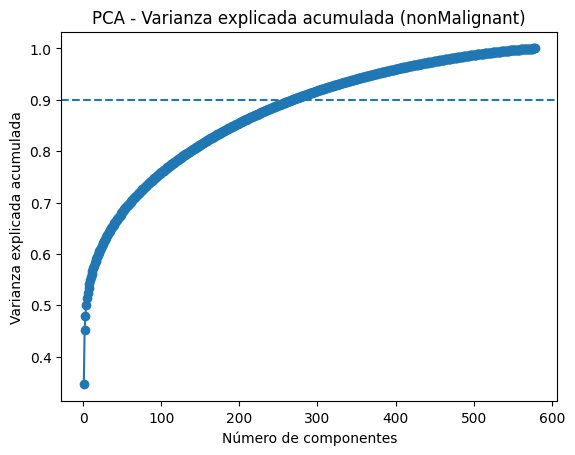

In [12]:
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_nm_scaled)

var_ratio = pca_full.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)

threshold = 0.90
n_components = int(np.searchsorted(cum_var_ratio, threshold) + 1)

print(f"\nNúmero de componentes para >= {threshold*100:.0f}% de varianza:",
      n_components)
print(f"Varianza explicada acumulada real con {n_components} PCs:",
      cum_var_ratio[n_components - 1])

plt.figure()
plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, marker="o")
plt.axhline(threshold, linestyle="--")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA - Varianza explicada acumulada (nonMalignant)")
plt.show()

In [13]:
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_nm_scaled)

print("Shape de X_pca:", X_pca.shape)

Shape de X_pca: (578, 268)


### Outliers

In [14]:
X_pca_nm = pd.DataFrame(
    X_pca,
    index=meta_nm.index,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])],
)

outliers_nm = flag_pca_distance_outliers(
    X_pca=X_pca_nm,
    quantile=0.99,
    center="mean",
)

In [15]:
meta_nm = meta_nm.copy()
meta_nm["is_outlier_pca"] = outliers_nm
meta_nm[meta_nm["is_outlier_pca"] == True]

,Sample ID,Patient_group,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,lib.size,classificationScoreCancer,Class_group,is_outlier_pca
Sample ID,,,,,,,,,,,,,
Vumc-HD-121-TR1113,Vumc-HD-121-TR1113,Asymptomatic controls,n.a.,M,25.0,Institute 13,0,1,0,310663,0.744609,nonMalignant,True
UMCU-HC-1-0210-TR819,UMCU-HC-1-0210-TR819,Asymptomatic controls,n.a.,F,52.0,Institute 10,0,0,1,33566,0.879523,nonMalignant,True
Vumc-HD-136-TR1125,Vumc-HD-136-TR1125,Asymptomatic controls,n.a.,F,20.0,Institute 13,0,1,0,638117,0.500000,nonMalignant,True
Vumc-HD-225-TR1884,Vumc-HD-225-TR1884,Asymptomatic controls,n.a.,F,55.0,Institute 13,1,0,0,373195,0.901284,nonMalignant,True
Vumc-MS-055-TR1586,Vumc-MS-055-TR1586,Multiple sclerosis,n.a.,F,47.0,Institute 13,0,0,1,262569,0.858153,nonMalignant,True
NKI-SARC-7330-TR3050,NKI-SARC-7330-TR3050,Former sarcoma,n.a.,F,60.0,Institute 5,0,0,1,100797,0.818064,nonMalignant,True


## UMAP

In [16]:
#  UMAP sobre las componentes principales 

X_umap, umap_model = compute_umap_from_pca(
    X_pca,
    n_neighbors=15,
    min_dist=0.3,
    random_state=RANDOM_STATE,
)

print("Shape UMAP:", X_umap.shape)

/workspaces/TFM/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape UMAP: (578, 2)


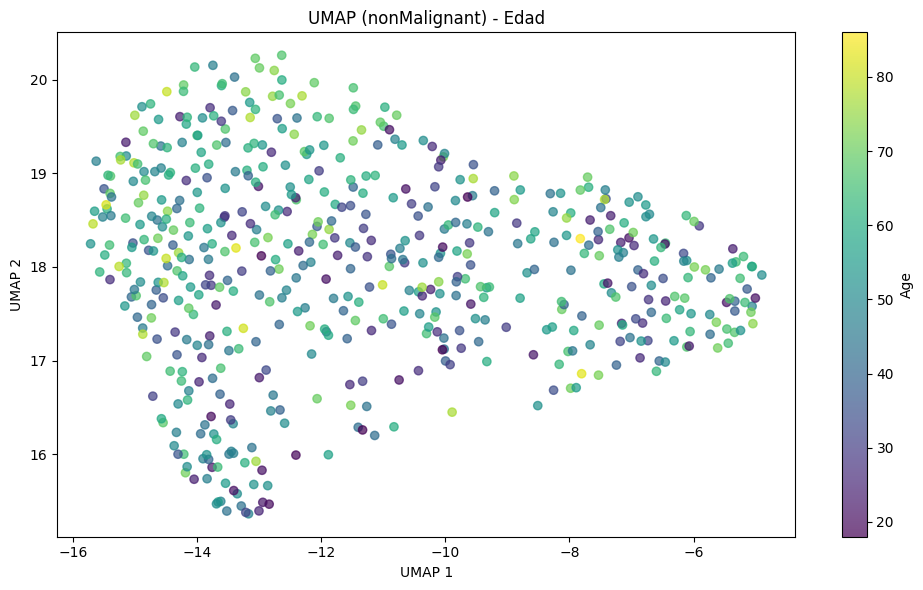

In [17]:
plot_umap(
    X_umap=X_umap,
    color=meta_nm["Age"],
    title="UMAP (nonMalignant) - Edad",
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    cmap="viridis",
    figsize = (10,6)
)

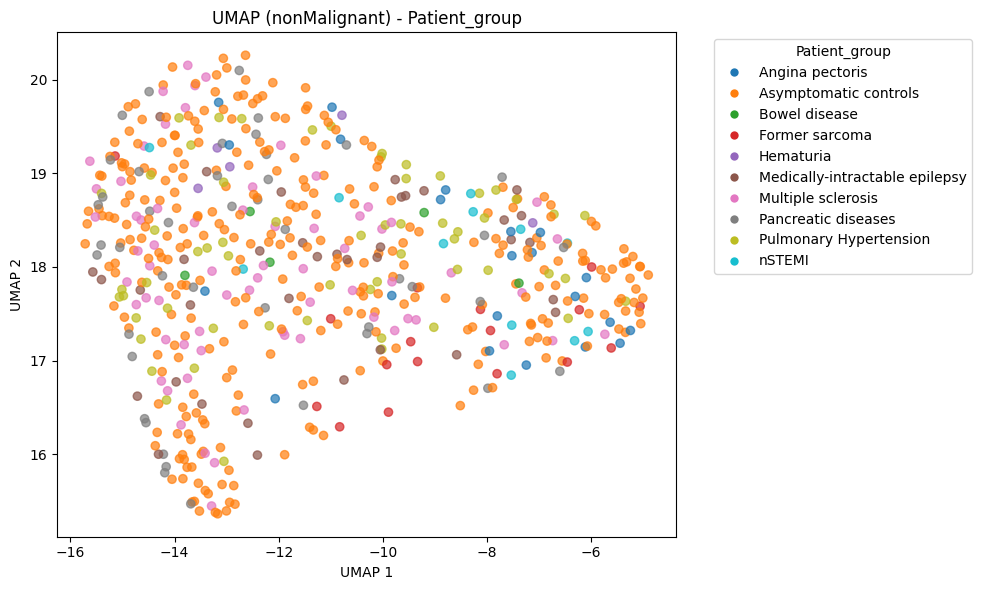

In [18]:
plot_umap(
    X_umap=X_umap,
    color=meta_nm["Patient_group"],
    title="UMAP (nonMalignant) - Patient_group",
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    figsize = (10,6)
)

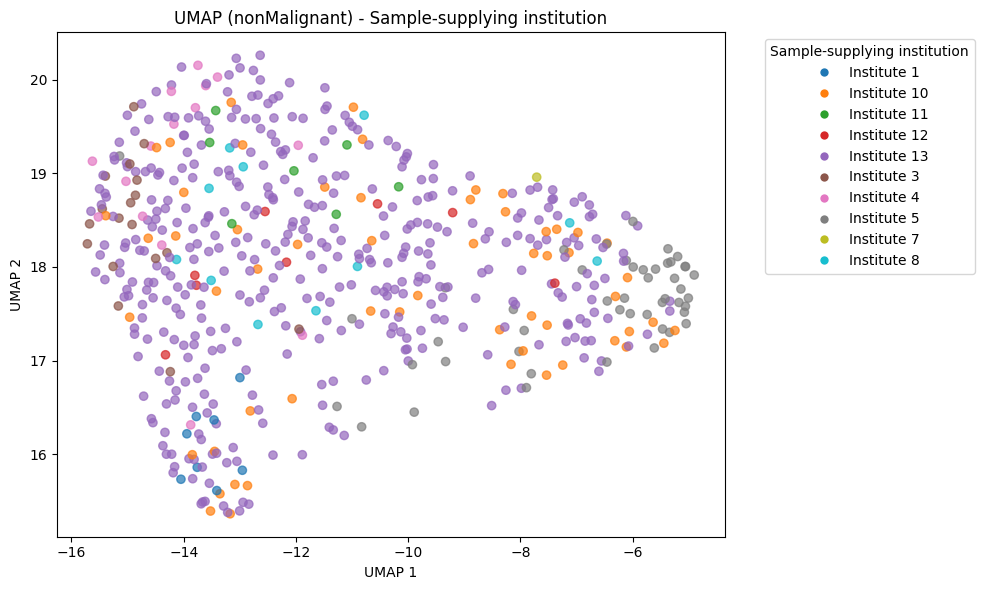

In [19]:
plot_umap(
    X_umap=X_umap,
    color=meta_nm["Sample-supplying institution"],
    title="UMAP (nonMalignant) - Sample-supplying institution",
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    figsize = (10,6)
)

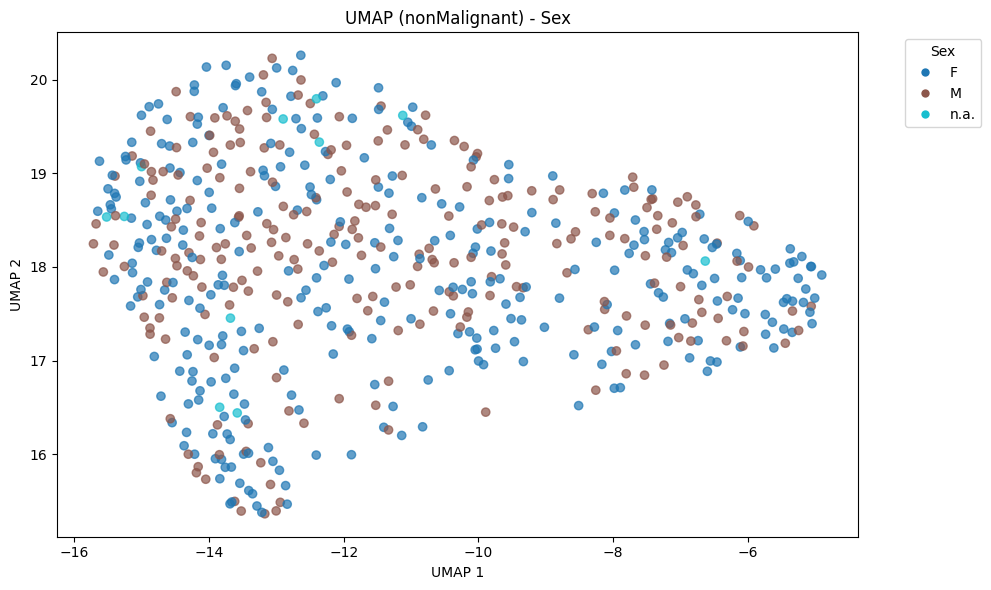

In [20]:
plot_umap(
    X_umap=X_umap,
    color=meta_nm["Sex"],
    title="UMAP (nonMalignant) - Sex",
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    figsize = (10,6)
)

## CLUSTERING

In [21]:
best_clust, df_clust_results, all_clust_results = search_best_clustering(
    X_pca,
    n_clusters_range=range(2, 11),
    random_state=RANDOM_STATE,
)

print("Mejor algoritmo:", best_clust["modelo"])
print("Mejor número de clusters:", best_clust["n_clusters"])
print("Silhouette:", best_clust["silhouette"])

labels_best = best_clust["labels"]
meta_nm["cluster_auto"] = labels_best


n=2 | kmeans sil=0.282, gmm sil=0.282, agg_ward sil=0.261 
n=3 | kmeans sil=0.142, gmm sil=0.142, agg_ward sil=0.203 
n=4 | kmeans sil=0.146, gmm sil=0.146, agg_ward sil=0.162 
n=5 | kmeans sil=0.145, gmm sil=0.145, agg_ward sil=0.122 
n=6 | kmeans sil=0.145, gmm sil=0.145, agg_ward sil=0.120 
n=7 | kmeans sil=0.143, gmm sil=0.143, agg_ward sil=0.099 
n=8 | kmeans sil=0.089, gmm sil=0.089, agg_ward sil=0.050 
n=9 | kmeans sil=0.065, gmm sil=0.065, agg_ward sil=0.053 
n=10 | kmeans sil=0.064, gmm sil=0.064, agg_ward sil=0.045 

Mejor configuración:
{'modelo': 'kmeans', 'n_clusters': 2, 'params': {'n_clusters': 2}, 'silhouette': 0.28160618092705103, 'calinski_harabasz': 229.7555187531496, 'davies_bouldin': 1.3871018905323027}
Mejor algoritmo: kmeans
Mejor número de clusters: 2
Silhouette: 0.28160618092705103


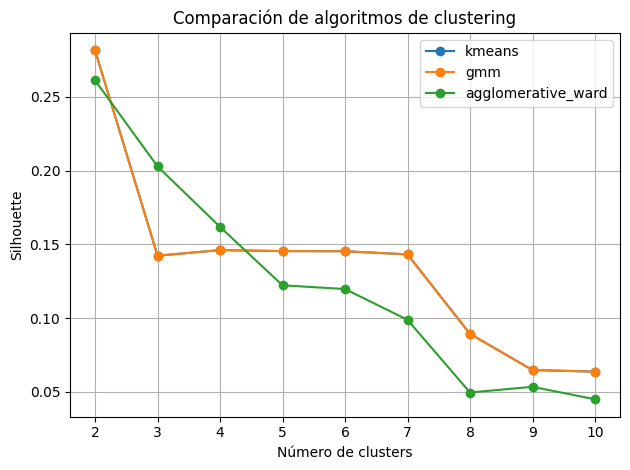

In [22]:
plt.figure()
for modelo in df_clust_results["modelo"].unique():
    subset = df_clust_results[df_clust_results["modelo"] == modelo]
    plt.plot(
        subset["n_clusters"],
        subset["silhouette"],
        marker="o",
        label=modelo,
    )

plt.xlabel("Número de clusters")
plt.ylabel("Silhouette")
plt.title("Comparación de algoritmos de clustering")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

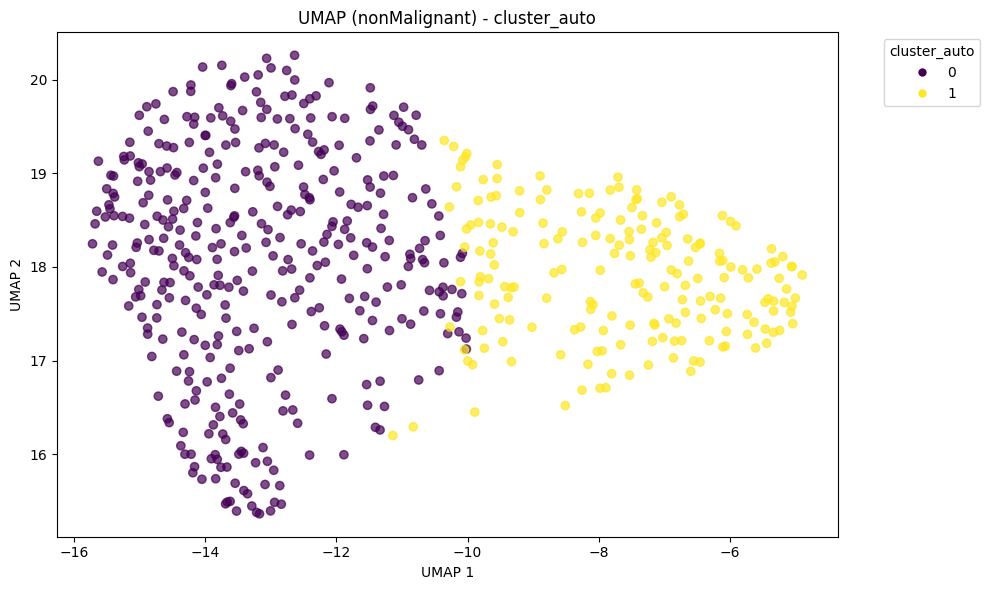

In [23]:
plot_umap(
    X_umap=X_umap,
    color=meta_nm["cluster_auto"],
    title="UMAP (nonMalignant) - cluster_auto",
    cmap="viridis",
    figsize = (10,6)
)

### Resultados estadísticos

In [24]:
meta_nm["cluster_auto"].value_counts()

cluster_auto
0    385
1    193
Name: count, dtype: int64

In [25]:
pd.crosstab(meta_nm["cluster_auto"], meta_nm["Sex"])

Sex,F,M,n.a.
cluster_auto,,,
0,208,167,10
1,111,81,1


No parece haber un sesgo fuerte de sexo entre clusters.

In [26]:
pd.crosstab(meta_nm["cluster_auto"], meta_nm["Sample-supplying institution"])

Sample-supplying institution,Institute 1,Institute 10,Institute 11,Institute 12,Institute 13,Institute 3,Institute 4,Institute 5,Institute 7,Institute 8
cluster_auto,,,,,,,,,,
0,8,29,6,6,291,18,15,3,0,9
1,0,28,1,2,114,0,0,45,1,2


Los resultados sugieren que la composición por institución sí influye en el clustering. Esto puede ser parte de la heterogeneiudad biológica o por posibles diferencias en sus métodos experimentales.

In [27]:
pd.crosstab(meta_nm["cluster_auto"], meta_nm["Patient_group"])

Patient_group,Angina pectoris,Asymptomatic controls,Bowel disease,Former sarcoma,Hematuria,Medically-intractable epilepsy,Multiple sclerosis,Pancreatic diseases,Pulmonary Hypertension,nSTEMI
cluster_auto,,,,,,,,,,
0,6,221,3,3,4,22,54,35,34,3
1,16,89,2,14,1,14,14,9,25,9


Los dos clusters parecen reflejar diferencias en el perfil clínico dentro de nonMalignant, es decir, un cluster 0 con más controles asintomáticos, y el otro con más pacientes con patologías no malignas “serias”.

In [28]:
meta_nm.groupby("cluster_auto")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_auto,,,,,,,,
0,375.0,50.978667,15.756997,18.0,40.0,52.0,63.0,83.0
1,193.0,49.854922,16.154517,18.0,39.0,51.0,63.0,86.0


No hay gran diferencia de edad entre clusters.

Esto es coherente con la idea de que los perfiles de expresión de plaquetas reflejan tanto el estado clínico como posibles factores técnicos. Vamos a validar estas conclusiones

#### Tests de asociación categórica y ANOVA


In [29]:
# Patient_group
tabla_pg = pd.crosstab(meta_nm["cluster_auto"], meta_nm["Patient_group"])
chi2_pg, p_pg, dof_pg, exp_pg = chi2_contingency(tabla_pg)
print("Chi2 Patient_group vs cluster:", chi2_pg, "p-value:", p_pg)

# Institución
tabla_inst = pd.crosstab(meta_nm["cluster_auto"], meta_nm["Sample-supplying institution"])
chi2_inst, p_inst, dof_inst, exp_inst = chi2_contingency(tabla_inst)
print("Chi2 Institución vs cluster:", chi2_inst, "p-value:", p_inst)

Chi2 Patient_group vs cluster: 57.476918491165655 p-value: 4.094797956456628e-09
Chi2 Institución vs cluster: 115.067475444192 p-value: 1.3622492948287353e-20


In [30]:
groups_age = [g["Age"].dropna().values for _, g in meta_nm.groupby("cluster_auto")]
F_age, p_age = f_oneway(*groups_age)
print("ANOVA edad vs cluster: F=", F_age, "p=", p_age)

ANOVA edad vs cluster: F= 0.6370386165853246 p= 0.4251199399299158


#### Heatmap para la parte de reports 

In [31]:
de_df = run_nonmalignant_cluster_characterization(
    X_log=X_nm_log,
    meta=meta_nm,
    cluster_col="cluster_auto",
    output_dir=output_dir_figure,
    top_n_genes=50,
    save_csv=False,
    save_heatmap=True,
)